### Polynomial Linear Regression

In [69]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
from IPython.core.pylabtools import figsize
sns.set()

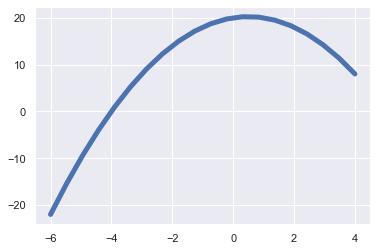

In [31]:
x = np.linspace(-6,4,20)
y = - (x**2) + x + 20
plt.plot(x,y, lw = 5)
plt.show()

In [32]:
with pm.Model() as model:
    alpha = pm.Normal('alpha',0,10)
    beta1 = pm.Normal('beta1',0,10)
    beta2 = pm.Normal('beta2',0,10)
    
    mu = alpha  + beta1 * x + beta2 * (x**2)
    yhat = pm.Normal('yhat',mu = mu, sigma = 2, observed = y)
    
    trace = pm.sample(1000, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


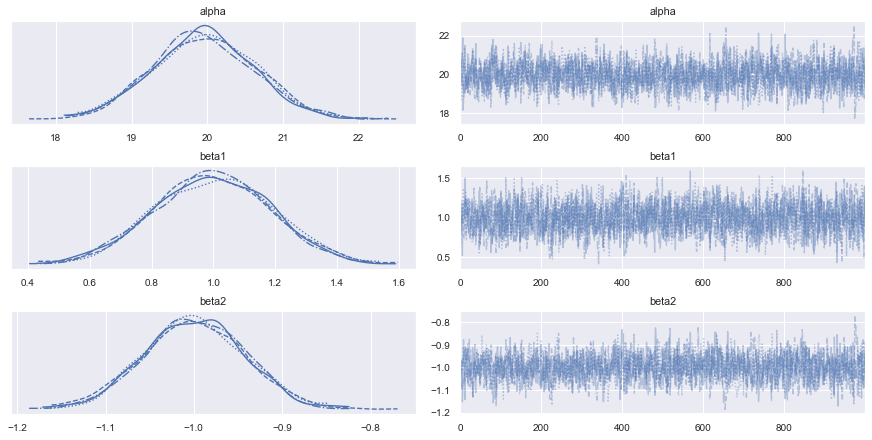

In [34]:
az.plot_trace(trace)
plt.show()

In [35]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,19.959,0.670,18.637,21.133,0.016,0.011,1834.0,2304.0,1.0
beta1,0.998,0.185,0.649,1.345,0.004,0.003,1804.0,2062.0,1.0
beta2,-0.999,0.056,-1.105,-0.898,0.001,0.001,1627.0,2040.0,1.0


In [60]:
np.random.seed(314)

M = 2
N = 100
alpha_real = 2.5
beta_real = [0.9,1.5]
eps_real = np.random.normal(0,0.5, size = N)
X = np.array([np.random.normal(i,j, N) for i, j in zip([10,2],[1,1.5])])
X_mean = X.mean(axis = 1, keepdims = True)
X_centered = X - X_mean
y = alpha_real + np.dot(beta_real, X) + eps_real

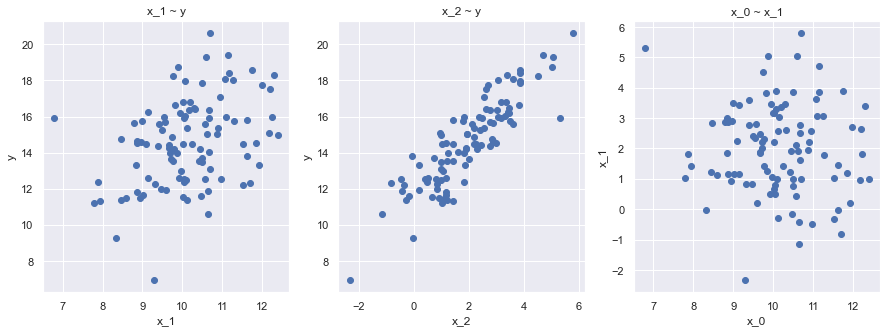

In [77]:
figsize(15,5)

for i in range(X.shape[0]):
    plt.subplot(1,3,i + 1)
    plt.scatter(X[i,:],y)
    plt.xlabel("x_{}".format(i + 1))
    plt.ylabel('y')
    plt.title('x_{} ~ y'.format(i+1))
    
plt.subplot(1,3,X.shape[0] + 1)
plt.scatter(X[0,:],X[1,:])
plt.xlabel('x_0')
plt.ylabel('x_1')
plt.title('x_0 ~ x_1')
plt.show()

#### How to include non-centered coef, the true alpha in model [beta is the same]
$n$:= number of records      
$m$:= number of features       
$X$: [m,n] data dimension comes last         
$\beta$: [1,m]


$y = \alpha + \beta X$              
$y = \alpha^{'} + \beta (X - X_{mean})$                      
$y = \alpha^{'} - \beta X_{mean} + \beta X $               
$\alpha^{'}  = \alpha - \beta X_{mean}$

In [81]:
with pm.Model() as model:
    alpha_c = pm.Normal('alpha_c',0,10)
    beta = pm.Normal('beta',0,10, shape = M)
    eps = pm.HalfNormal('eps',10)
    mu = alpha_c + pm.math.dot(beta, X_centered)
    alpha = pm.Deterministic('apha',alpha_c - pm.math.dot(beta, X_mean))
    yhat = pm.Normal('yhat',mu, eps, observed = y)
    trace = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta, alpha_c]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


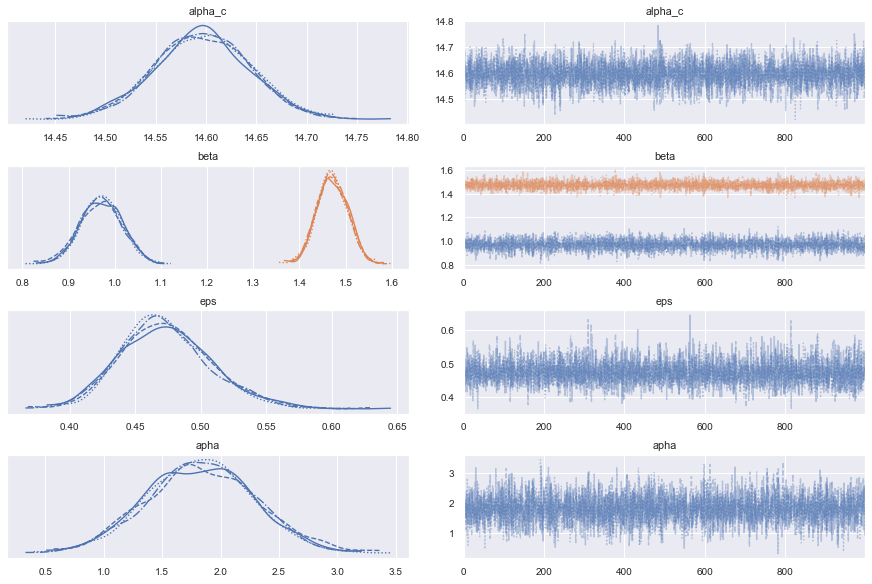

In [83]:
az.plot_trace(trace)
plt.show()

In [84]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_c,14.596,0.047,14.501,14.678,0.001,0.000,4800.0,3144.0,1.0
beta[0],0.971,0.044,0.887,1.053,0.001,0.000,5117.0,3160.0,1.0
beta[1],1.471,0.033,1.409,1.530,0.000,0.000,5904.0,2939.0,1.0
eps,0.473,0.034,0.412,0.540,0.000,0.000,5562.0,2517.0,1.0
apha[0],1.828,0.461,0.959,2.683,0.007,0.005,4927.0,3183.0,1.0


#### Confonding Variables

$x_1 \rightarrow x_2$: causation         
$x_1 \rightarrow y$: causation    
$x_2$ ~ $y$: correlation  

In [118]:
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=1)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2))

X_mean = X.mean(axis = 1, keepdims = True)
X_centered = X - X_mean

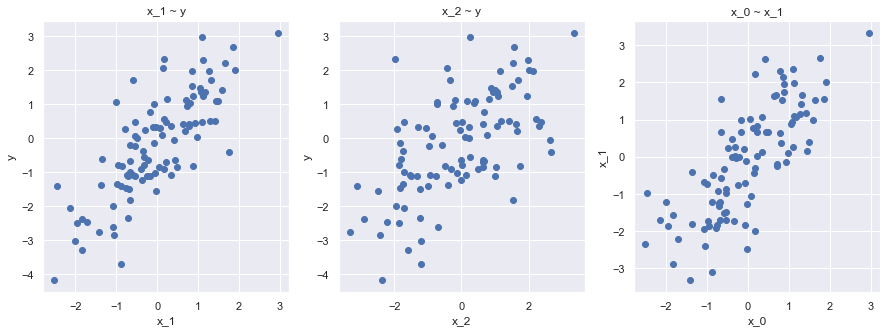

In [119]:
figsize(15,5)

for i in range(X.shape[0]):
    plt.subplot(1,3,i + 1)
    plt.scatter(X[i,:],y)
    plt.xlabel("x_{}".format(i + 1))
    plt.ylabel('y')
    plt.title('x_{} ~ y'.format(i+1))
    
plt.subplot(1,3,X.shape[0] + 1)
plt.scatter(X[0,:],X[1,:])
plt.xlabel('x_0')
plt.ylabel('x_1')
plt.title('x_0 ~ x_1')
plt.show()

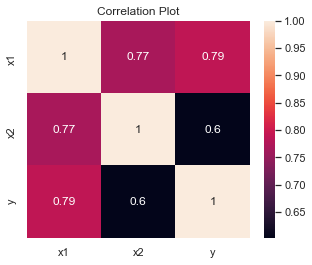

In [120]:
plt.figure(figsize=(5,4))
sns.heatmap(np.corrcoef(np.vstack((X,y))),
            annot=True,xticklabels=['x1','x2','y'], 
            yticklabels= ['x1','x2','y'])
plt.title('Correlation Plot')
plt.show()

In [121]:
with pm.Model() as model:
    alpha_c = pm.Normal('alpha_c',0,10)
    beta = pm.Normal('beta',0,10, shape = M)
    eps = pm.HalfNormal('eps',10)
    mu = alpha_c + pm.math.dot(beta, X_centered)
    alpha = pm.Deterministic('apha',alpha_c - pm.math.dot(beta, X_mean))
    yhat = pm.Normal('yhat',mu, eps, observed = y)
    trace = pm.sample(10000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta, alpha_c]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 32 seconds.


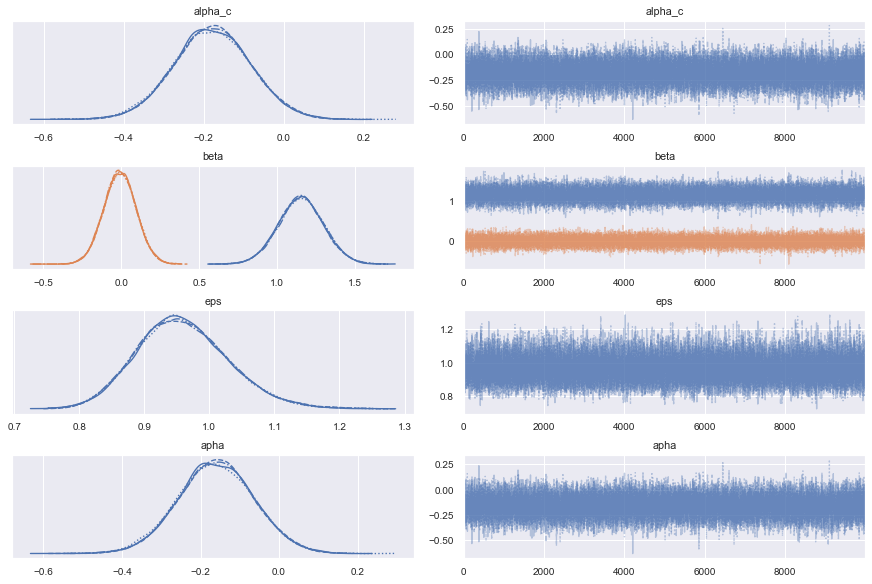

In [122]:
az.plot_trace(trace)
plt.show()

In [123]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_c,-0.179,0.096,-0.363,-0.001,0.001,0.000,33955.0,27278.0,1.0
beta[0],1.152,0.144,0.883,1.427,0.001,0.001,27673.0,24666.0,1.0
beta[1],-0.010,0.103,-0.200,0.188,0.001,0.001,27352.0,25592.0,1.0
eps,0.959,0.070,0.827,1.090,0.000,0.000,28979.0,22681.0,1.0
apha[0],-0.160,0.096,-0.338,0.026,0.001,0.000,33994.0,27200.0,1.0


$\beta_{1} = 1.152$            
$\beta_{2} = -0.01$  
$x2$ has nearly null effect on $y$

**Only use x1 as predictor**

In [126]:
M1 = 1

In [130]:
with pm.Model() as model:
    alpha_c = pm.Normal('alpha_c',0,10)
    beta = pm.Normal('beta',0,10, shape = M1)
    eps = pm.HalfNormal('eps',10)
    mu = alpha_c + pm.math.dot(beta, X_centered[0,:].reshape(1,-1))
    alpha = pm.Deterministic('apha',alpha_c - pm.math.dot(beta, X_mean[0,:].reshape(1,-1)))
    yhat = pm.Normal('yhat',mu, eps, observed = y)
    trace = pm.sample(10000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta, alpha_c]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 30 seconds.


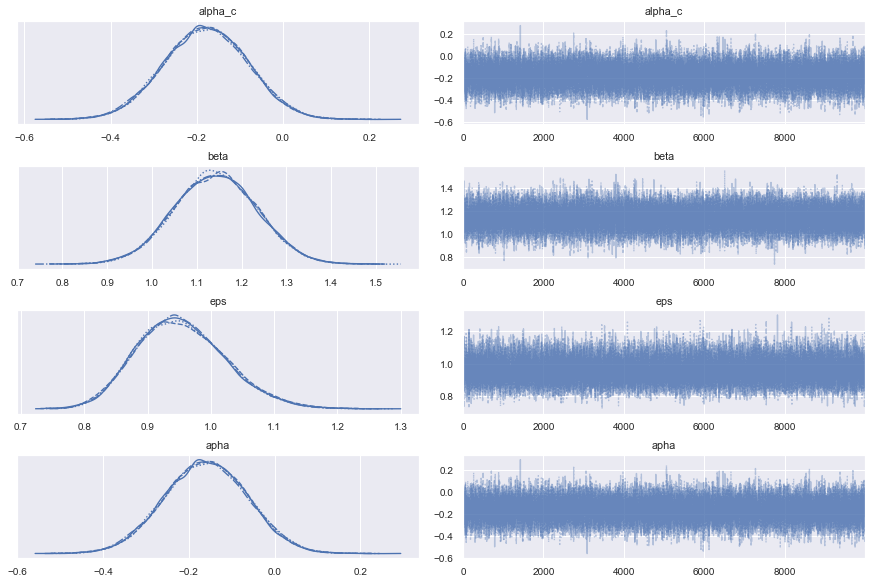

In [131]:
az.plot_trace(trace)
plt.show()

In [132]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_c,-0.179,0.096,-0.358,0.004,0.0,0.0,52529.0,28117.0,1.0
beta[0],1.141,0.092,0.976,1.320,0.0,0.0,52566.0,29992.0,1.0
eps,0.954,0.070,0.829,1.089,0.0,0.0,52257.0,26409.0,1.0
apha[0],-0.160,0.097,-0.335,0.026,0.0,0.0,52509.0,28165.0,1.0


$\beta = 1.141$

**Only use x2 as predictor variable**

In [133]:
with pm.Model() as model:
    alpha_c = pm.Normal('alpha_c',0,10)
    beta = pm.Normal('beta',0,10, shape = M1)
    eps = pm.HalfNormal('eps',10)
    mu = alpha_c + pm.math.dot(beta, X_centered[1,:].reshape(1,-1))
    alpha = pm.Deterministic('apha',alpha_c - pm.math.dot(beta, X_mean[1,:].reshape(1,-1)))
    yhat = pm.Normal('yhat',mu, eps, observed = y)
    trace = pm.sample(10000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta, alpha_c]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 30 seconds.


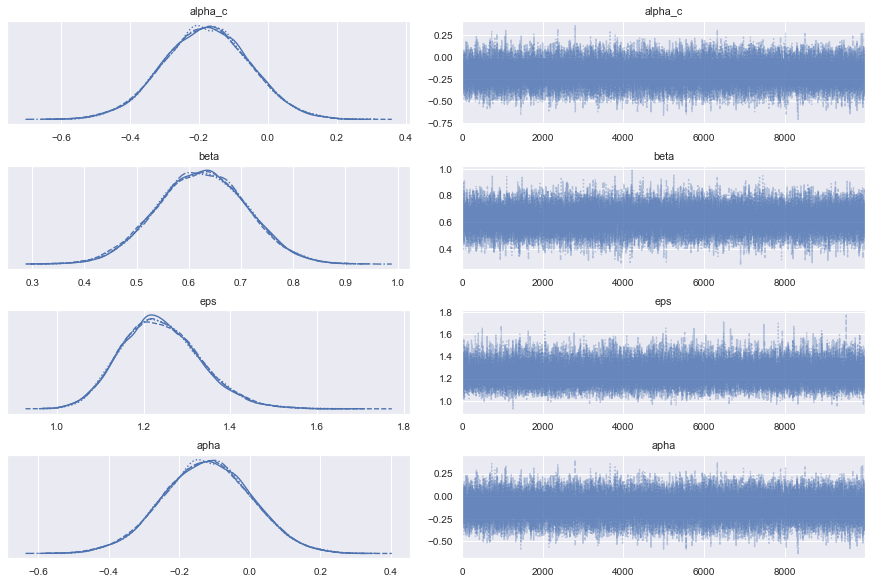

In [134]:
az.plot_trace(trace)
plt.show()

In [135]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_c,-0.178,0.126,-0.409,0.064,0.001,0.000,53985.0,29688.0,1.0
beta[0],0.625,0.086,0.461,0.783,0.000,0.000,51763.0,29088.0,1.0
eps,1.240,0.092,1.073,1.412,0.000,0.000,51248.0,28061.0,1.0
apha[0],-0.121,0.126,-0.359,0.114,0.001,0.001,53876.0,29671.0,1.0


$\beta = 0.625$

Take Aways: 当我们把真正有影响的$x1$ 加进去的时候， $x2$这个中间变量的解释能力就变弱了。   

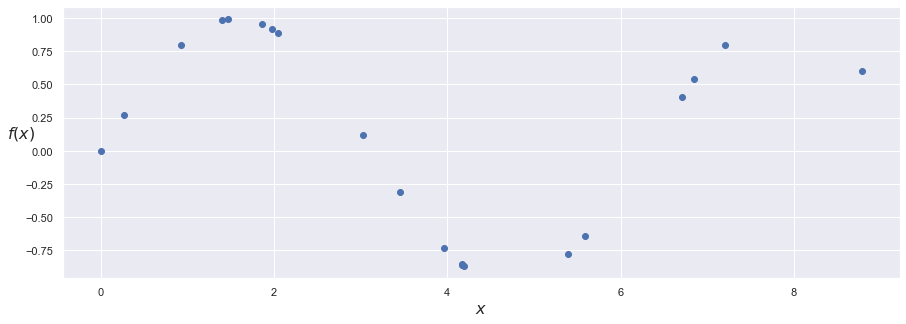

In [137]:
np.random.seed(1)
x = np.random.uniform(0, 10, size=20)
y = np.sin(x)
plt.plot(x, y, 'o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)
plt.show()

#### Kernel Based Methods

$K(x,x') = exp(-\frac{||x-x'||^2}{w})$

你定义了几个knot点，让每个点到这些knot点计算一个距离，然后用那个kernel函数搞一下         
两个点越近，越相似， kernel值越小.   
这个就相当于，使用这些knots点，为数据点添加了一个similarity

In [141]:
n_knots = 5
w = 2
knots = np.linspace(np.floor(x.min()), np.ceil(x.max()), n_knots)

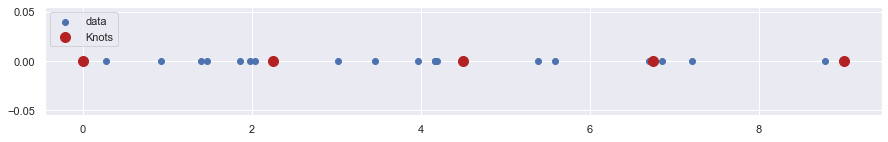

In [164]:
plt.subplots(figsize = (15,2))
plt.scatter(x,np.zeros(len(x)), label = 'data')
plt.scatter(knots, np.zeros(n_knots), color = 'firebrick',s = 100, label = 'Knots')
plt.legend(loc = 'upper left')
plt.show()

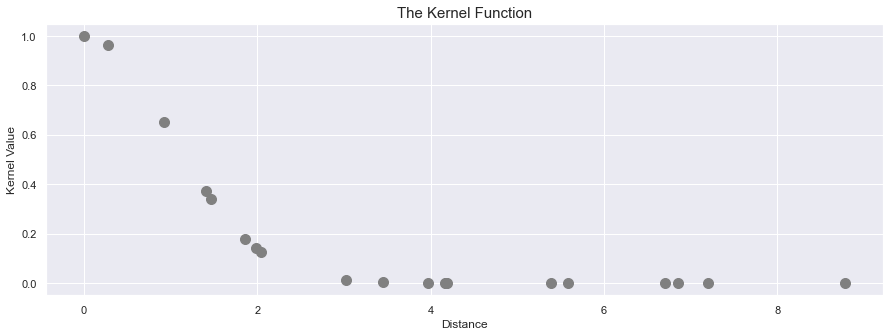

In [174]:
distance = x - knots[0]
kernel_value = np.exp(-(x-knots[0])**2/w)
plt.scatter(distance, kernel_value, s = 100, color = 'gray')
plt.xlabel('Distance')
plt.ylabel('Kernel Value')
plt.title('The Kernel Function', fontsize = 15)
plt.show()

**Define a Gauss Kernel**

In [175]:
def gauss_kernel(x, n_knots=5, w=2):
    """
    Simple Gaussian radial kernel
    """
    knots = np.linspace(np.floor(x.min()), np.ceil(x.max()), n_knots)
    return np.array([np.exp(-(x-k)**2/w) for k in knots])

In [179]:
kernelized_x = gauss_kernel(x)

In [180]:
kernelized_x.shape

(5, 20)

$\mu = \alpha + \beta x + \sum \gamma_i K_i(x,x')$

In [182]:
n_knots = 5

In [225]:
with pm.Model() as kernel_model:
    alpha = pm.Normal('alpha', 0,5)
    beta = pm.Normal('beta',0,5)
    gamma = pm.Cauchy('gamma', alpha=0, beta=1, shape=n_knots)
    sd = pm.Uniform('sd',0, 2)
    mu = alpha + beta*x + pm.math.dot(gamma, gauss_kernel(x, n_knots))
    yl = pm.Normal('yl', mu=mu, sd=sd, observed=y)
    trace = pm.sample(30000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, gamma, beta, alpha]


Sampling 4 chains for 1_000 tune and 30_000 draw iterations (4_000 + 120_000 draws total) took 180 seconds.
There were 5058 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4039 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3480 divergences after tuning. Increase `target_accept` or reparameterize.
There were 271 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


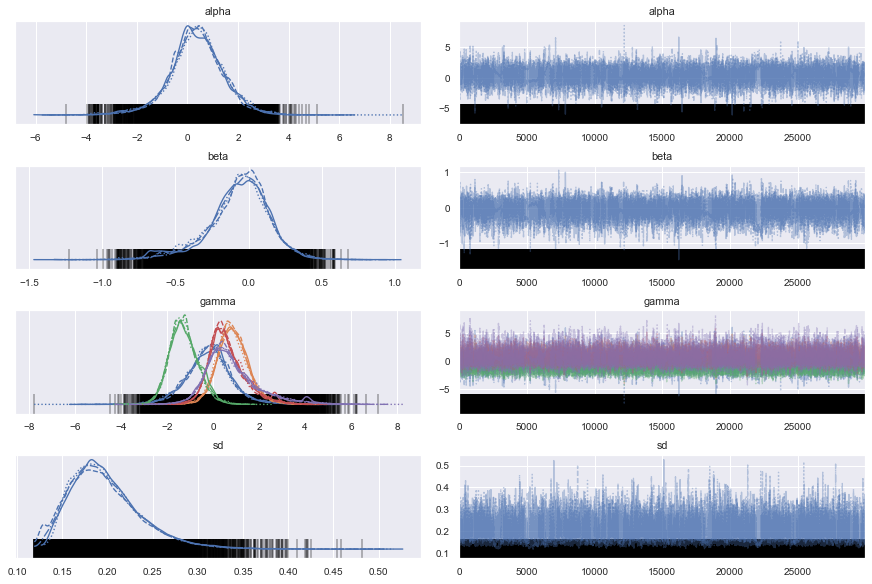

In [226]:
az.plot_trace(trace)
plt.show()

In [227]:
with kernel_model:
    ppc = pm.sample_posterior_predictive(
        trace, var_names=['yl'], random_seed=42
    )

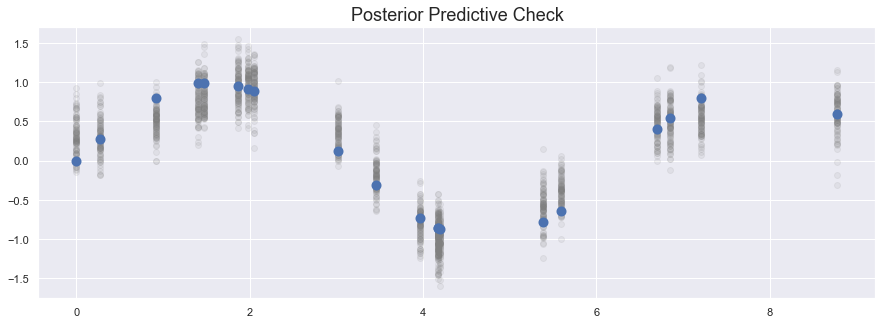

In [228]:
for t in ppc["yl"][-100:,:]:
    plt.scatter(x,t, color = 'gray', alpha = 0.1)
plt.scatter(x, y, lw = 4)
plt.title('Posterior Predictive Check', fontsize = 18)
plt.show()

In [229]:
summary = az.summary(trace)

In [230]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.370,1.082,-1.643,2.528,0.017,0.012,3635.0,3679.0,1.00
beta,-0.068,0.213,-0.504,0.329,0.005,0.004,2619.0,1179.0,1.00
gamma[0],-0.179,1.013,-2.207,1.708,0.016,0.012,3663.0,3762.0,1.00
gamma[1],0.848,0.695,-0.423,2.203,0.009,0.007,5445.0,7229.0,1.00
gamma[2],-1.275,0.629,-2.403,-0.053,0.009,0.007,4677.0,7103.0,1.00
gamma[3],0.603,0.805,-0.795,2.245,0.016,0.013,3133.0,1457.0,1.00
gamma[4],0.800,1.169,-1.119,3.285,0.026,0.021,2877.0,1282.0,1.00
sd,0.198,0.040,0.128,0.270,0.001,0.001,1094.0,610.0,1.01


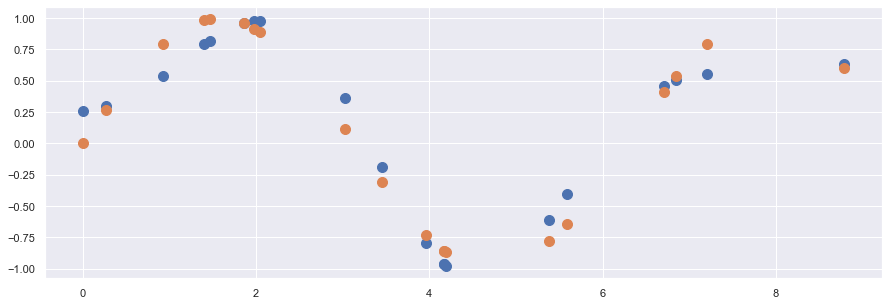

In [231]:
gamma_val = az.summary(trace, var_names = 'gamma')['mean'].values
alpha_val = summary.loc['alpha','mean']
beta_val = summary.loc['beta','mean']
plt.scatter(x, alpha_val + beta_val*x + np.dot(gamma_val, gauss_kernel(x, n_knots)), s = 100, label = 'Predicted')
plt.scatter(x,y,s = 100, label = 'Actual')